# Exercise 3: Real-time evolution of the Ising model

We want to compute the real-time evolution of an initial state $|\psi_0\rangle$ under the Ising Hamiltonian
$$H = \sum_{i=0}^{N-2} Z_iZ_{i+1} + h\sum_{i=0}^{N-1} X_i$$
using a trotterized version of the time-evolution operator 
$$U(\Delta t)\approx \prod_{k=0}^{N-2} \exp\left(-i Z_kZ_{k+1} \Delta t\right) \prod_{k=0}^{N-1} \exp\left(-i hX_{k} \Delta t\right).$$
Thus, we can obtain 
$$|\psi(n\Delta t)\rangle = U(\Delta t)^n|\psi_0\rangle.$$

In the following we use $N=4$ and the initial state
$$|\psi_0\rangle = |0010\rangle$$.

## Imports from the Qiskit package

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import *
from qiskit.quantum_info import state_fidelity
# Numpy and Scipy for data evaluation and reference calculations
import numpy as np
from scipy.linalg import expm
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Magic function to render plots in the notebook after the cell executing the plot command
%matplotlib inline

### Function for convenience which allows for running the simulator and extracting the results

In [2]:
# Function for convenience which allows for running the simulator and extracting the results
def run_on_qasm_simulator(quantum_circuit, num_shots):
    """Takes a circuit, the number of shots and a backend and returns the counts for running the circuit
    on the qasm_simulator backend."""
    qasm_simulator = Aer.get_backend('qasm_simulator')
    job = execute(quantum_circuit, backend=qasm_simulator, shots=num_shots)
    result = job.result()
    counts = result.get_counts()
    return counts

### Function providing the exact solution for the magnetization for comparison

In [3]:
def Op(M, n ,N):
    """Given a single site operator, provide the N-body operator 
    string obtained by tensoring identities"""
    d = M.shape[0]
    id_left = np.eye(d**n)
    id_right = np.eye(d**(N-n-1))
    res = np.kron(id_left,np.kron(M,id_right))
    return res

def IsingHamiltonian(N, h):
    """The Ising Hamiltonian for N sites with parameter h"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    H = np.zeros((2**N, 2**N))
    for i in range(N):
        if i<N-1:            
            H += Op(Z, i, N)@Op(Z, i+1, N)
        H += h*Op(X, i, N)
    return H            

# For reference, we provide a function computing the exact solution for
# the magnetization as a function of time
def get_magnetization_vs_time(h, delta_t, nsteps):
    """Compute the exact value of the magnetization"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    Id = np.eye(2)
    # The Ising Hamiltonian for 4 sites with parameter h
    H = IsingHamiltonian(4, h)
    # The time evolution operator for an interval \Delta t
    U = expm(-1.0j*delta_t*H)
    # The operator for the total magnetization
    M = Op(Z,0,4) + Op(Z,1,4) + Op(Z,2,4) + Op(Z,3,4)
    # Numpy array to hold the results
    magnetization = np.zeros(nsteps)
    # The initial wave function corresponding to |0010>
    psi = np.zeros(16)
    psi[int('0010', 2)] = 1
    # Evolve in steps of \Delta t and measure the magnetization
    for n in range(nsteps):
        psi = U@psi
        magnetization[n] = np.real(psi.conj().T@M@psi)
    return magnetization

##  <font color='orange'>Initial state</font> 

Complete the following function which provides a quantum circuit creating the initial state $|0010\rangle$ (all qubits in state zero, except for qubit 2). Note that we still need to evolve the state in time, you do not need to add any measurements at the end.

In [4]:
def provide_initial_state():
    # Create a quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the necessary gate(s) to provide the inital state |0010>
    qc.x(2)    
    return qc

##  <font color='orange'>The $exp\left(-i Z_kZ_{k+1} \Delta t\right)$ part of the time-evolution operator</font>

Complete the following function which provides the $exp\left(-i Z_kZ_{k+1} \Delta t\right)$ of the time evolution operator. Note that we still need to evolve the state in time, you do not need to add any measurements at the end.

In [5]:
def Uzz(delta_t):
    # Create an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the gates for exp(-i Z_k Z_k+1 \Delta t) for all neighboring qubits
    for i in range(3):
        qc.rzz(2.0*delta_t, i, i+1)
    return qc

##  <font color='orange'>The $exp\left(-i hX_k \Delta t\right)$ part of the time-evolution operator</font>

Complete the following function which provides the $exp\left(-i hX_k \Delta t\right)$ of the time evolution operator. Note that we still need to evolve the state in time, you do not need to add any measurements at the end.

In [6]:
def Ux(delta_t, h):
    # Create an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the gates for exp(-i h X_k \Delta t) to all qubits
    for i in range(4):        
        qc.rx(2.0*delta_t*h, i)
    return qc

## Functions for the time evoltuon

After building the circuit implementing the initial state and the parts of the time evolution operator, the first of following functions allows for building the total circuit evolving the initial state in time by N steps.

The second function allows for computing the magnetization given the counts resulting from a measurement.

In [7]:
def build_time_evolution_circuit(qc_init_state, qc_Uzz, qc_Ux, N):
    """Given the circuits implementing the initial state and the two parts
    of the trotterized time-evolution operator build the circuit evolving the 
    wave function N steps
    """
    # Generate an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the inital state
    qc += qc_init_state
    # For each time step add qc_Uzz and qc_Ux
    for i in range(N):
        qc += qc_Uzz
        qc += qc_Ux
    # Add the final measurments
    qc.measure_all()
    return qc

In [8]:
def get_magnetization(counts):
    """Given the counts resulting form a measurement, compute the site
    resolved magnetization"""
    total_counts = sum(counts.values())
    res = np.zeros(4)
    for qubit in range(4):
        Z_expectation = 0.
        for key, value in counts.items():
            if key[qubit] == '0':
                Z_expectation += value
            else:
                Z_expectation -= value
        res[qubit] = Z_expectation/total_counts
    return res

## <font color='orange'>Run the evolution and visualize the results</font>

In [9]:
# The parameters for the time evolution
h = 1.5
delta_t = 0.05
nsteps = 40
nshots = 1000

# Provide the initial state
qc_init_state = provide_initial_state()
# The time-evolution operators
qc_Uzz = Uzz(delta_t)
qc_Ux = Ux(delta_t,h)

In [10]:
# Numpy array for expectation values of the magnetization
magnetization = np.zeros(nsteps)
# Numpy array for qubit configuration
configuration = np.zeros((4, nsteps))
# Run the time evolution
for n in range(1, nsteps+1):
    # Build the evolution circuit out of qc_init_state, qc_Uzz and qc_Ux for 
    # n steps
    qc_evo = build_time_evolution_circuit(qc_init_state, qc_Uzz, qc_Ux, n)
    # Run the evolution circuit on the qasm_simulator
    res = run_on_qasm_simulator(qc_evo, nshots)
    # Compute the ovservables
    configuration[:,n-1] = get_magnetization(res)    
    magnetization[n-1] = sum(configuration[:,n-1])
# For reference we compute the exact solution
magnetization_exact = get_magnetization_vs_time(h, delta_t, nsteps)

Text(0.5, 1.0, 'Spatially resolved spin configuration')

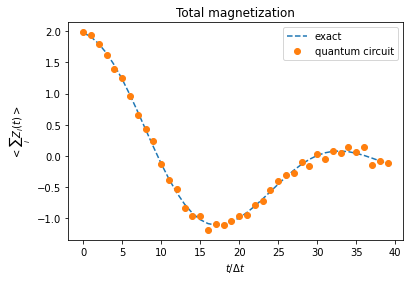

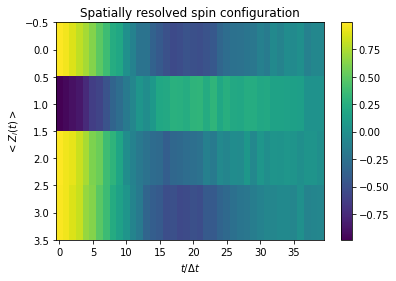

In [11]:
# Plot the total magnetization as a function of time and compare to
# the exact result
plt.figure()
plt.plot(magnetization_exact, '--', label='exact')
plt.plot(magnetization, 'o', label='quantum circuit')
plt.xlabel('$t/\Delta t$')
plt.ylabel('$<\sum_i Z_i(t)>$')
plt.title('Total magnetization')
plt.legend()

# Plot the site resolved spin configuration as a function of time
plt.figure()
plt.imshow(configuration, aspect='auto')
plt.colorbar()
plt.xlabel('$t/\Delta t$')
plt.ylabel('$<Z_i(t)>$')
plt.title('Spatially resolved spin configuration')

## <font color='green'>Optional tasks</font>

The solution for the problem above can be more elegant by using parameterized circuits keeping the parameters $\Delta t$ and $h$ in $U_{zz}$ and $U_x$ dynamical and binding them to a certain value before evaluation. Following the tutorial [here](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html#Parameterized-circuits) try to solve the problem above using parameterized circuits.

In [19]:
# Import the package for working with parameters
from qiskit.circuit import Parameter

# Define parameters, the arguments define the symbols that are shown if we
# draw the circuit
dt = Parameter('Δt')
h = Parameter('h')

In [20]:
def Uzz_parameterized(param_delta_t):
    # Create an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the gates for exp(-i Z_k Z_k+1 \Delta t) for all neighboring qubits
    for i in range(3):
        qc.rzz(2.0*param_delta_t, i, i+1)
    return qc

In [21]:
def Ux_parameterized(param_delta_t, param_h):
    # Create an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    for i in range(4):
        # Add the exp(-i \Delta t Z_k Z_k+1) gates
        qc.rx(2.0*param_delta_t*param_h, i)
    return qc

In [22]:
# The parameters for the time evolution (now we can conveniently check 
# for multiple values of h since we have a parameterized circuit)
h_values = [1.0, 1.2 , 1.5]
delta_t = 0.05
nsteps = 40
nshots = 1000

# Provide the initial state
qc_init_state = provide_initial_state()
# The time-evolution operators
qc_Uzz = Uzz_parameterized(dt)
qc_Ux = Ux_parameterized(dt, h)

In [23]:
# Numpy array for expectation values of the magnetization
magnetization = np.zeros((len(h_values), nsteps))
# Run the time evolution
for n in range(1, nsteps+1):
    # Build the evolution circuit out of qc_init_state, qc_Uzz and qc_Ux for 
    # n steps
    qc_evo = build_time_evolution_circuit(qc_init_state, qc_Uzz, qc_Ux, n)    
    # Now we bind the parameter \Delta t
    qc_evo = qc_evo.bind_parameters({dt: delta_t})
    # Now we bind the parameters for h and get a list of circuits, one for each value of h
    circs = [qc_evo.bind_parameters({h: h_value}) for h_value in h_values]
    # Run the evolution circuits on the qasm_simulator
    res = run_on_qasm_simulator(circs, nshots)
    # Compute the ovservables (now res is a list of counts with one entry for each different value of h)
    for i in range(len(res)):
        configuration = get_magnetization(res[i])
        magnetization[i, n-1] = sum(configuration)
        
# For reference we compute the exact solutions
magnetization_exact = np.zeros((len(h_values), nsteps))
for i in range(len(h_values)):
    magnetization_exact[i,:] = get_magnetization_vs_time(h_values[i], delta_t, nsteps)

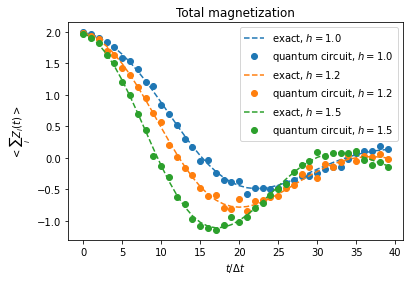

In [24]:
# Plot the total magnetization as a function of time and compare to
# the exact result
plt.figure()
for i in range(len(h_values)):
    hf = plt.plot(magnetization_exact[i,:], '--', label='exact, $h = ' + str(h_values[i]) + '$')
    plt.plot(magnetization[i,:], 'o', label='quantum circuit, $h = ' + str(h_values[i]) + '$', c=hf[0].get_color())
plt.xlabel('$t/\Delta t$')
plt.ylabel('$<\sum_i Z_i(t)>$')
plt.title('Total magnetization')
plt.legend()